# Stock price prediction machine learning models

### Introduction
When investors are choosing which stocks to buy and when to buy them, they look to buy the stocks that will give them the greatest returns. To forecast if a stock price will go up or down, investors may use fundamental and technical analysis. Fundamental analysis involves looking at a company's financial data, and the stock's intrinsic value vs its current price. Technical analysis involves viewing the stock's price trends over time to try and predict where it could go next.

This stock price prediction program aims to be a tool for investors when they are using technical analysis to try and predict where a stock may go in the short-term. When the user runs this program, it will ask for an input and the user can input any stock ticker from a stock that was in the S&P 500 in 2018.

### Set-up and imports

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import sys

In [2]:
#Load dataset into pandas DataFrame
dataset = pd.read_csv('all_stocks_5yr.csv', sep=',', encoding='latin-1')

In [3]:
#Display first row of data
dataset.head(1)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL


### Display stock tickers
The dataset I loaded in contains years of data on every stock in the S&P 500. I wanted a way to display every ticker that the user can choose from, but it takes up a lot of space when run so it is currently commented out. The line of code displays all the unique values from the 'Name' column. The .unique() function returns only the unique elements of an array, which is important because there are many rows with the same ticker in the 'Name' column and I don't want the same ticker displaying hundreds of times.

In [4]:
#Run the line below to display all unique tickers in the S&P 500 from 2018
#print(dataset.Name.unique())

## Input (User Input Required)
Here, I made a variable called 'chosen_ticker' and then I ask for an input from the user. The variable is assigned to the user's input. I then have an if statement to determine if the ticker that the user entered is a ticker in the dataset. If it is, the ticker they selected is displayed, and the next segment of code is run. If the ticker they inputted is not found in the dataset, a message is displayed telling the user that the ticker they entered was invalid, and to restart the kernal and try again, and the script terminates so that the code doesn't go on to try and build models with no data which would output loads of errors.

In [5]:
#Input any S&P 500 ticker from 2018. For example, PYPL (PayPal).
chosen_ticker = input("Enter a ticker: ")

Enter a ticker: PYPL


In [6]:
if chosen_ticker in dataset.Name.unique():
    print("Chosen ticker: "+chosen_ticker)
else:
    print("The ticker you have entered is invalid, please restart the kernel")
    sys.exit()

Chosen ticker: PYPL


### Extract and clean data
I then extract all the rows of data from the dataset that are relevant to the ticker the user inputted. I do this by collecting each row of data with 'Name' the same as the user inputted ticker, and I store this in a variable called 'chosen_stock'.

I then clean this data by dropping any rows with null values, because if there are any null values there would be errors when trying to build the models. This would still badly affect our result if rows were dropped because each row is a day of data, but luckily the dataset is very clean already and I have not encounter any null values in the stocks I have tested.

In [7]:
#Extract all data pertaining to user inputted ticker
extracted_data = dataset['Name'] == chosen_ticker
#Put all the extracted rows of user inputted stock in a variable
chosen_stock = dataset[extracted_data]
#Display first row of data from variable with user inputted stock data
chosen_stock.head(1)

,date,open,high,low,close,volume,Name
474054,2015-07-06,38.0,39.75,36.0,36.71,5866647,PYPL


In [8]:
#Clean data by dropping rows with null values
chosen_stock = chosen_stock.dropna()

### Extract close prices
I then extract the data even further and this time I just take 'close' column data and store it in a variable called close_data. This variable will be used in both our models.

In [9]:
#Filter out the closing market price data
close_data = chosen_stock.filter(['close'])

## Long Short-Term Memory (LSTM) model
LSTM is a recurrent neural network architecture used in machine learning. LSTM is used for many types of machine learning including speech recognition and handwriting recognition. It is widely used and is known to be very effective.

### Create data for training the model
To create the data for training my LSTM model, I first converted my close price data that I extracted above into an array. Next I moved on to normalizing the data to fit all the values between 0 and 1 which will make our model more accurate. I did this using the fit_transform() method which takes in our close price array and gets the mean and variance of each value in the array, and then transforms these values using the respective mean and variance.

I then create the training data size by getting the length of our close prices array and multiplying it by 0.7, and storing that in 'training_data_length'. I then create 'train_data' and assign it to 70% of the scaled data.

Next I seperated the data into x_train and y_train. Then I gave 60 days of close price data.

I then converted the x and y training data to numpy arrays so I could go on to convert the data into a 3-dimensional data set using .reshape(), which is the data we can now use to train the LSTM model.

In [10]:
#Convert data into array
close_data_array = close_data.values

#Normalize data to make all values between 0 and 1
#Define min max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
#Transform the data
scaled_data = scaler.fit_transform(close_data_array)

#Creating training data size (70% of the data)
training_data_length = math.ceil(len(close_data_array) *.7)
train_data = scaled_data[0:training_data_length  , : ]

#Separating data into x_train and y_train
x_train_data=[]
y_train_data =[]
#Give 60 days of close price data
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    #Converting x and y training data to numpy arrays
    x_train_data1 = np.array(x_train_data)
    y_train_data1 = np.array(y_train_data)
 
    #Reshaping training x and y data for building model
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

### Build the model
Here, I define the LSTM model. It will have two LSTM layers with 50 LSTM units and two Dense layers, one with 25 units and the other with one unit.

In [11]:
#Define model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

### Compile the model

I compile the LSTM model using the mean squared error loss function and the adam optimizer.

Using the fit() function, I am feeding the training data into the model. Batch_size is the total number of training examples present in the single batch, which I've set to 1. Epochs are the number of times the entire data set is passed forward and backward through the neural network (A data set being passed forward and backwards through a neural network counts as 1 epoch).

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

399/399 [==============================] - 8s 15ms/step - loss: 9.9008e-04


### Test the model on test data

Here I get all the rows above 'training_data_length' from the column of the closing price. Then I convert the x_test data set into the numpy arrays so that they can be used to train the LSTM model.

As the LSTM model is expecting the data in 3-dimensional data set, I use the reshape() function.

Then, using the predict() function, I get the predicted values from the model using the test data. The line with scaler.inverse_transform() is undoing the scaling.

In [13]:
#Creating a dataset for testing
test_data = scaled_data[training_data_length - 60: , : ]
x_test = []
y_test = close_data_array[training_data_length : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
#Convert x_test into 3-dimensional data set
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
#Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

### Measure accuracy of model

I create the variable root_mse and assign it to the root mean squared error. This is to measure the accuracy of the model. The lower the value, the better.

In [14]:
root_mse = np.sqrt(np.mean(((predictions- y_test)**2)))
print(root_mse)

10.720073682585575


### Visualize results

The final step of testing this model is to plot the data.

<ipython-input-15-6563e750b2b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


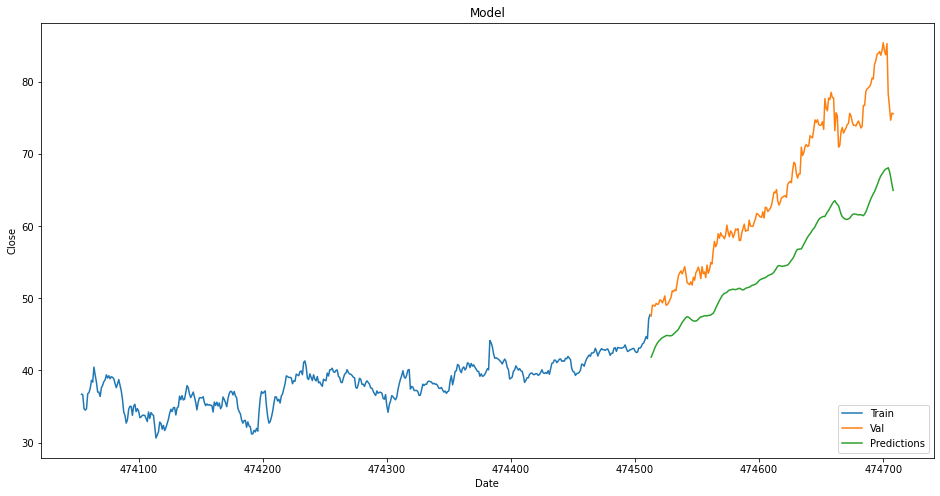

In [15]:
train = chosen_stock[:training_data_length]
valid = chosen_stock[training_data_length:]
 
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()

## Decision Tree model
Here, I've made a decision tree learning algorithm to try and predict the stock price.

I start by creating a new variable called future_days and assign it to 25, as I will be tring to predict the next 25 days' closing prices.

I then take my closing prices data, and I make a new column called 'Prediction'. I then shift the index of this column up by the variable 'future_days' which is currently equal to 25. Then I display the top 3 rows of the dataset to show the new column.

In [16]:
#Create variable to predict x days into the future
future_days = 25

#Create new column shifted x days up where x is the variable 'future_days'
close_data['Prediction'] = close_data[['close']].shift(-future_days)
close_data.head(3)

,close,Prediction
474054,36.71,39.05
474055,36.62,38.85
474056,34.70,38.19


### Create training data

To start creating the training data, I create a new data set called X, and assign it to the closing prices with the prediction column dropped converted to a numpy array. I need all the rows except for the last 25 (Or whatever the future_days variable is assigned to), which is what the last part of that line does.

In [17]:
#Create feature data set (X), convert it to numpy array and remove last x days
X = np.array(close_data.drop(['Prediction'],1))[:-future_days]
print(X)

[[36.71 ]
 [36.62 ]
 [34.7  ]
 [34.5  ]
 [34.69 ]
 [36.78 ]
 [36.93 ]
 [37.51 ]
 [38.63 ]
 [38.39 ]
 [40.47 ]
 [39.35 ]
 [38.39 ]
 [37.01 ]
 [37.   ]
 [36.39 ]
 [37.6  ]
 [37.95 ]
 [38.45 ]
 [38.7  ]
 [39.39 ]
 [38.95 ]
 [39.27 ]
 [38.85 ]
 [39.13 ]
 [39.05 ]
 [38.85 ]
 [38.19 ]
 [37.62 ]
 [38.14 ]
 [38.73 ]
 [37.99 ]
 [37.19 ]
 [35.98 ]
 [34.25 ]
 [33.75 ]
 [32.7  ]
 [33.17 ]
 [34.62 ]
 [35.04 ]
 [35.   ]
 [33.77 ]
 [35.07 ]
 [35.31 ]
 [34.29 ]
 [34.7  ]
 [34.37 ]
 [33.46 ]
 [33.55 ]
 [33.77 ]
 [33.8  ]
 [33.77 ]
 [33.32 ]
 [32.92 ]
 [34.25 ]
 [33.35 ]
 [34.16 ]
 [33.91 ]
 [33.77 ]
 [32.25 ]
 [30.63 ]
 [31.04 ]
 [31.48 ]
 [32.83 ]
 [32.67 ]
 [31.86 ]
 [32.38 ]
 [31.67 ]
 [32.06 ]
 [32.63 ]
 [33.22 ]
 [34.05 ]
 [34.62 ]
 [34.29 ]
 [34.84 ]
 [34.87 ]
 [33.83 ]
 [34.79 ]
 [34.99 ]
 [36.44 ]
 [35.94 ]
 [36.52 ]
 [35.91 ]
 [36.01 ]
 [36.99 ]
 [37.9  ]
 [37.6  ]
 [36.71 ]
 [36.24 ]
 [36.6  ]
 [37.   ]
 [36.33 ]
 [35.57 ]
 [34.53 ]
 [35.61 ]
 [36.21 ]
 [36.22 ]
 [36.19 ]
 [36.36 ]
 [35.56 ]


Then I create a new data set called Y, and assign it to the all the data in closing prices converted to a numpy array except the last 'future_days' days of data.

In [18]:
#Create target data set (Y), convert it to numpy array and get all the data except the last 'future_days' rows
Y = np.array(close_data['Prediction'])[:-future_days]
print(Y)

[39.05  38.85  38.19  37.62  38.14  38.73  37.99  37.19  35.98  34.25
 33.75  32.7   33.17  34.62  35.04  35.    33.77  35.07  35.31  34.29
 34.7   34.37  33.46  33.55  33.77  33.8   33.77  33.32  32.92  34.25
 33.35  34.16  33.91  33.77  32.25  30.63  31.04  31.48  32.83  32.67
 31.86  32.38  31.67  32.06  32.63  33.22  34.05  34.62  34.29  34.84
 34.87  33.83  34.79  34.99  36.44  35.94  36.52  35.91  36.01  36.99
 37.9   37.6   36.71  36.24  36.6   37.    36.33  35.57  34.53  35.61
 36.21  36.22  36.19  36.36  35.56  35.12  35.36  35.18  35.26  35.17
 35.15  34.23  35.62  35.16  35.6   35.07  35.49  34.69  35.01  36.32
 35.98  35.54  34.98  36.08  36.805 37.11  37.07  36.61  37.08  36.48
 36.2   34.75  34.31  33.98  33.13  32.69  33.04  33.08  32.12  32.87
 32.31  32.2   31.2   31.2   31.69  31.47  31.97  31.59  34.24  36.14
 37.08  36.83  37.01  37.17  35.07  33.61  32.7   32.9   33.52  34.3
 35.46  36.36  36.31  35.76  36.    35.48  36.47  36.74  37.49  38.14
 39.25  39.16  39.02 

### Split data

Next, using the train_test_split method which splits the array into random train and test subsets. I'm passing in my X and Y data sets that I created above, and the test size is set to 0.25 or 25%.

In [19]:
#Split the data into 75% training and 25% testing
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25)

### Create model

Next I create the decision tree regressor model. Just like for the LSTM model, I use the fit() function to feed the training data into the model.

In [20]:
#Create decision tree regressor model
tree = DecisionTreeRegressor().fit(x_train,y_train)

I then need to get the last 25 rows of closing data with the prediction column dropped and convert it to an array.

In [21]:
#Get the last x rows of the X data set
#Drop prediction column and get all rows except last 25
x_future = close_data.drop(['Prediction'], 1)[:-future_days]
#Get the rows of last 25 days
x_future = x_future.tail(future_days)
#Convert to numpy array
x_future = np.array(x_future)
#Display
x_future

array([[77.84],
       [77.79],
       [73.25],
       [75.73],
       [75.3 ],
       [70.97],
       [71.2 ],
       [73.14],
       [73.69],
       [72.91],
       [73.29],
       [73.62],
       [74.09],
       [74.26],
       [75.65],
       [75.32],
       [74.5 ],
       [74.  ],
       [74.02],
       [73.89],
       [74.27],
       [74.59],
       [74.17],
       [73.62],
       [73.84]])

Next I display the values that the model predicted.

In [22]:
#Show the model tree prediction
tree_prediction = tree.predict(x_future)
print(tree_prediction)

[76.75  76.73  78.7   79.05  79.19  78.605 79.75  78.7   80.42  82.47
 82.94  79.76  83.78  84.21  83.71  84.34  85.45  84.31  83.78  85.32
 78.4   85.45  74.705 79.76  75.59 ]


### Visualize results

The final step is to visualise the data from the tree predictions.

<ipython-input-23-a65525f71597>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = tree_prediction


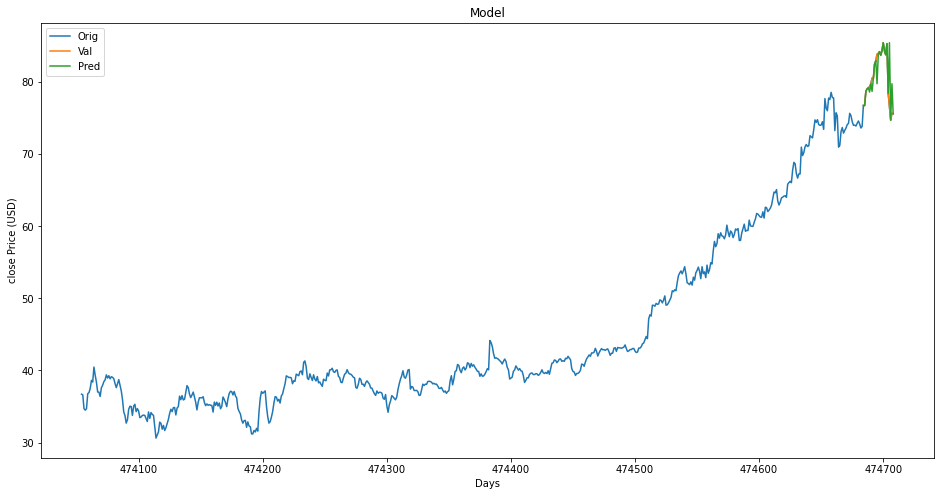

In [23]:
#Visualise data
valid = chosen_stock[X.shape[0]:]
valid['Predictions'] = tree_prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Days')
plt.ylabel('close Price (USD)')
plt.plot(chosen_stock['close'])
plt.plot(valid[['close','Predictions']])
plt.legend(['Orig','Val','Pred'])
plt.show()